MNIST Handwritten Digit Classification
Assignment 3: AI/ML for Industry

Comparing 5 Classification Methods:
1. K-Nearest Neighbors (KNN)
2. Logistic Regression
3. Naive Bayes
4. Support Vector Machines (SVM)
5. Random Forest

Analysis with and without PCA dimensionality reduction

In [2]:
# CRITICAL: Fix SSL verification error - MUST be first
import ssl
ssl._create_default_https_context = ssl._create_unverified_context


In [3]:
# CRITICAL: Fix SSL verification error - MUST be first
import ssl
ssl._create_default_https_context = ssl._create_unverified_context

import seaborn as sns
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (accuracy_score, precision_score, recall_score, 
                             f1_score, confusion_matrix, classification_report)
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
import time
import warnings
import ssl
import urllib.request
import matplotlib.pyplot as plt
import pandas as pd

# Fix SSL verification error - MUST be set before any network requests
ssl._create_default_https_context = ssl._create_unverified_context

warnings.filterwarnings('ignore')

SECTION 1: DATA LOADING AND PREPROCESSING

In [4]:
# Load MNIST dataset
print("Loading MNIST dataset...")
try:
    # Try to fetch from OpenML
    mnist = fetch_openml('mnist_784', version=1, parser='auto', as_frame=False)
    X, y = mnist.data, mnist.target
    print(f"✓ Dataset loaded successfully from OpenML")
except Exception as e:
    print(f"Error loading from OpenML: {e}")
    print("Trying alternative method with TensorFlow/Keras...")
    try:
        # Alternative: Use TensorFlow/Keras to load MNIST (no SSL issues)
        try:
            import tensorflow as tf
            (X_train, y_train), (X_test, y_test) = tf.keras.datasets.mnist.load_data()
            X = np.concatenate([X_train, X_test], axis=0).reshape(-1, 784)
            y = np.concatenate([y_train, y_test], axis=0)
            print(f"✓ Dataset loaded successfully from TensorFlow/Keras")
        except ImportError:
            print("TensorFlow not available. Trying sklearn digits as fallback...")
            from sklearn.datasets import load_digits
            digits = load_digits()
            X, y = digits.data, digits.target
            print("Note: Using digits dataset (smaller than MNIST)")
    except Exception as e2:
        print(f"All methods failed: {e2}")

print(f"✓ Dataset loaded successfully")
print(f"  Total samples: {X.shape[0]}")
print(f"  Features per sample: {X.shape[1]}")
print()

Loading MNIST dataset...
✓ Dataset loaded successfully from OpenML
✓ Dataset loaded successfully
  Total samples: 70000
  Features per sample: 784



In [5]:
# Select 2000 samples from test data (MNIST test data is last 10,000 samples)
print("Selecting 2000 samples from test data...")
# MNIST typically has 70,000 samples (60k train + 10k test)
# We'll take the last 2000 samples
# Note: X and y are numpy arrays, so use array slicing
X_subset = X[-2000:]
y_subset = y[-2000:].astype(int)

print(f"✓ Selected {len(X_subset)} samples")
print(f"  Shape: {X_subset.shape}")

Selecting 2000 samples from test data...
✓ Selected 2000 samples
  Shape: (2000, 784)


y is the digit classification output.

In [6]:
#Split the dataset into test and train 
X_train, X_test, y_train, y_test = train_test_split(X_subset, y_subset, test_size = 0.2, random_state=42, stratify=y_subset)

print(f"✓ Data split completed")
print(f"  Training samples: {X_train.shape[0]}")
print(f"  Testing samples: {X_test.shape[0]}")
print()

✓ Data split completed
  Training samples: 1600
  Testing samples: 400



In [7]:
# Normalize the data (scale pixel values from 0-255 to 0-1)
print("Normalizing pixel values (0-255 → 0-1)...")
X_train_normalized = X_train / 255.0
X_test_normalized = X_test / 255.0

print(f"✓ Normalization completed")
print(f"  Original range: [{X_train.min():.1f}, {X_train.max():.1f}]")
print(f"  Normalized range: [{X_train_normalized.min():.3f}, {X_train_normalized.max():.3f}]")
print()

Normalizing pixel values (0-255 → 0-1)...
✓ Normalization completed
  Original range: [0.0, 255.0]
  Normalized range: [0.000, 1.000]



In [8]:
print("="*80)
print("SECTION 1: DATA PREPARATION COMPLETE")
print("="*80)
print()
print()

SECTION 1: DATA PREPARATION COMPLETE




HELPER FUNCTION TO EVALUATE MODEL METRICS 

In [9]:
# Dictionary to store results
results_without_pca = []

# Helper function to evaluate model
def evaluate_model(y_true, y_pred, model_name):
    """Calculate and print evaluation metrics"""
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, average='micro', zero_division=0)
    recall = recall_score(y_true, y_pred, average='micro', zero_division=0)
    f1 = f1_score(y_true, y_pred, average='micro', zero_division=0)
    
    print(f"\n{model_name} - Performance Metrics:")
    print(f"  Accuracy:  {accuracy:.4f} ({accuracy*100:.2f}%)")
    print(f"  Precision: {precision:.4f}")
    print(f"  Recall:    {recall:.4f}")
    print(f"  F1-Score:  {f1:.4f}")
    
    return accuracy, precision, recall, f1

SECTION 2 CLASSIFICATION ALGORITHMS 

#--------------------------------------------------------------------------
# 1. LOGISTIC REGRESSION 

In [10]:
print("\nTraining Logistic Regression classifier...")
print("  Algorithm: Multinomial Logistic Regression for multi-class classification digits 0-9")
print("  Parameters: max_iter=1000, solver='lbfgs', multi_class='multinomial'")

start_time_logistic = time.time()
log_reg = LogisticRegression(max_iter=2000, solver='lbfgs', 
                              multi_class='multinomial', random_state=42, n_jobs=-1)
log_reg.fit(X_train_normalized, y_train)
lr_train_time = time.time() - start_time_logistic

print(f"✓ Training completed in {lr_train_time:.4f} seconds")


Training Logistic Regression classifier...
  Algorithm: Multinomial Logistic Regression for multi-class classification digits 0-9
  Parameters: max_iter=1000, solver='lbfgs', multi_class='multinomial'


✓ Training completed in 9.5051 seconds


In [11]:
# Make Predictions 
start_time_pred_logistic = time.time()
y_pred_lr = log_reg.predict(X_test_normalized)
lr_pred_time = time.time() - start_time_pred_logistic

print(f"✓ Predictions completed in {lr_pred_time:.4f} seconds")

✓ Predictions completed in 0.0059 seconds


In [12]:
# Evaluate model 
lr_metrics = evaluate_model(y_test, y_pred_lr, "LogisticRegression")

# Store results
results_without_pca.append({
    'Classifier': 'Logistic Regression',
    'Accuracy': lr_metrics[0],
    'Precision': lr_metrics[1],
    'Recall': lr_metrics[2],
    'F1-Score': lr_metrics[3],
    'Train Time (s)': lr_train_time,
    'Predict Time (s)': lr_pred_time
})

print(f"\nNote: Fast training and very fast prediction")
print(f"      Good baseline for linear decision boundaries")


LogisticRegression - Performance Metrics:
  Accuracy:  0.9350 (93.50%)
  Precision: 0.9350
  Recall:    0.9350
  F1-Score:  0.9350

Note: Fast training and very fast prediction
      Good baseline for linear decision boundaries


#--------------------------------------------------------------------------
# 2. K-NEAREST NEIGHBORS (KNN)

In [13]:
print("  Algorithm: K-Nearest Neighbors")
print("\nTraining KNN classifier...")
print("  Parameters: n_neighbors=5, weights='uniform'")

start_time_knn = time.time()
knn = KNeighborsClassifier(n_neighbors=5, weights = 'uniform', n_jobs = -1)

# Train the model
knn.fit(X_train_normalized, y_train)
knn_train_time = time.time() - start_time_knn

print(f"✓ Training completed in {knn_train_time:.4f} seconds")


  Algorithm: K-Nearest Neighbors

Training KNN classifier...
  Parameters: n_neighbors=5, weights='uniform'
✓ Training completed in 0.0059 seconds


In [14]:
print("\nMaking predictions...")
start_time_pred_knn = time.time()
y_pred_knn = knn.predict(X_test_normalized)
knn_pred_time = time.time() - start_time_pred_knn

print(f"✓ Predictions completed in {knn_pred_time:.4f} seconds")


Making predictions...
✓ Predictions completed in 3.0911 seconds


In [15]:
#Evaluate model 
knn_metrics = evaluate_model(y_test, y_pred_knn, "K Nearest Neigbors")

# Store results
results_without_pca.append({
    'Classifier': 'K Nearest Neigbors',
    'Accuracy': knn_metrics[0],
    'Precision': knn_metrics[1],
    'Recall': knn_metrics[2],
    'F1-Score': knn_metrics[3],
    'Train Time (s)': knn_train_time,
    'Predict Time (s)': knn_pred_time
})

print(f"\nNote: KNN has zero training time conceptually (lazy learner)")
print(f"      Prediction is slow as it searches all training samples")


K Nearest Neigbors - Performance Metrics:
  Accuracy:  0.9450 (94.50%)
  Precision: 0.9450
  Recall:    0.9450
  F1-Score:  0.9450

Note: KNN has zero training time conceptually (lazy learner)
      Prediction is slow as it searches all training samples


#---------------------------------------------------------------------
# 3. SUPPORT VECTOR MACHINES

In [16]:
print("  Algorithm: Support Vector Machine with RBF kernel")
print("  Parameters: kernel='rbf', C=5, gamma='scale'")
print("\nTraining SVM classifier...")

svm_start_time = time.time()
svm = SVC(kernel='rbf', C=5, gamma='scale', random_state=42)
svm.fit(X_train_normalized, y_train)
svm_train_time = time.time() - svm_start_time

print(f"✓ Training completed in {svm_train_time:.4f} seconds")

  Algorithm: Support Vector Machine with RBF kernel
  Parameters: kernel='rbf', C=5, gamma='scale'

Training SVM classifier...
✓ Training completed in 0.2716 seconds


In [17]:
# Making predictions 
svm_pred_start_time = time.time() 
y_pred_svm = svm.predict(X_test_normalized)
svm_pred_time = time.time() - svm_pred_start_time

print(f"✓ Predictions completed in {svm_pred_time:.4f} seconds") 

✓ Predictions completed in 0.1338 seconds


In [18]:
#Evaluate model 
svm_metrics = evaluate_model(y_test, y_pred_svm, "Support Vector Machines")

# Store results
results_without_pca.append({
    'Classifier': 'Support Vector Machines',
    'Accuracy': svm_metrics[0],
    'Precision': svm_metrics[1],
    'Recall': svm_metrics[2],
    'F1-Score': svm_metrics[3],
    'Train Time (s)': svm_train_time,
    'Predict Time (s)': svm_pred_time
})


Support Vector Machines - Performance Metrics:
  Accuracy:  0.9675 (96.75%)
  Precision: 0.9675
  Recall:    0.9675
  F1-Score:  0.9675


#---------------------------------------------------------------------
# 4. DECISION TREE CLASSIFIER

In [19]:
print("  Algorithm: DECISIONT TREE CLASSIFIER")
print("  Parameters: max_depth=20, min_samples_split=10, criterion='gini'")
print("\nTraining Decision Tree classifier...")

dt_start_time = time.time()
dt = DecisionTreeClassifier(max_depth=20, min_samples_split=10, 
                            criterion='gini', random_state=42)
dt.fit(X_train_normalized, y_train)
dt_train_time = time.time() - dt_start_time

print(f"✓ Training completed in {dt_train_time:.4f} seconds")

  Algorithm: DECISIONT TREE CLASSIFIER
  Parameters: max_depth=20, min_samples_split=10, criterion='gini'

Training Decision Tree classifier...
✓ Training completed in 0.1861 seconds


In [20]:
# Making predictions 
dt_pred_start_time = time.time()
y_pred_dt = dt.predict(X_test_normalized)
dt_pred_time = time.time() - dt_pred_start_time

print(f"✓ Predictions completed in {dt_pred_time:.4f} seconds")

✓ Predictions completed in 0.0028 seconds


In [21]:
#Evaluate model 
dt_metrics = evaluate_model(y_test, y_pred_dt, "Decision Trees")

# Store results
results_without_pca.append({
    'Classifier': 'Decision Trees',
    'Accuracy': dt_metrics[0],
    'Precision': dt_metrics[1],
    'Recall': dt_metrics[2],
    'F1-Score': dt_metrics[3],
    'Train Time (s)': dt_train_time,
    'Predict Time (s)': dt_pred_time
})


Decision Trees - Performance Metrics:
  Accuracy:  0.7500 (75.00%)
  Precision: 0.7500
  Recall:    0.7500
  F1-Score:  0.7500


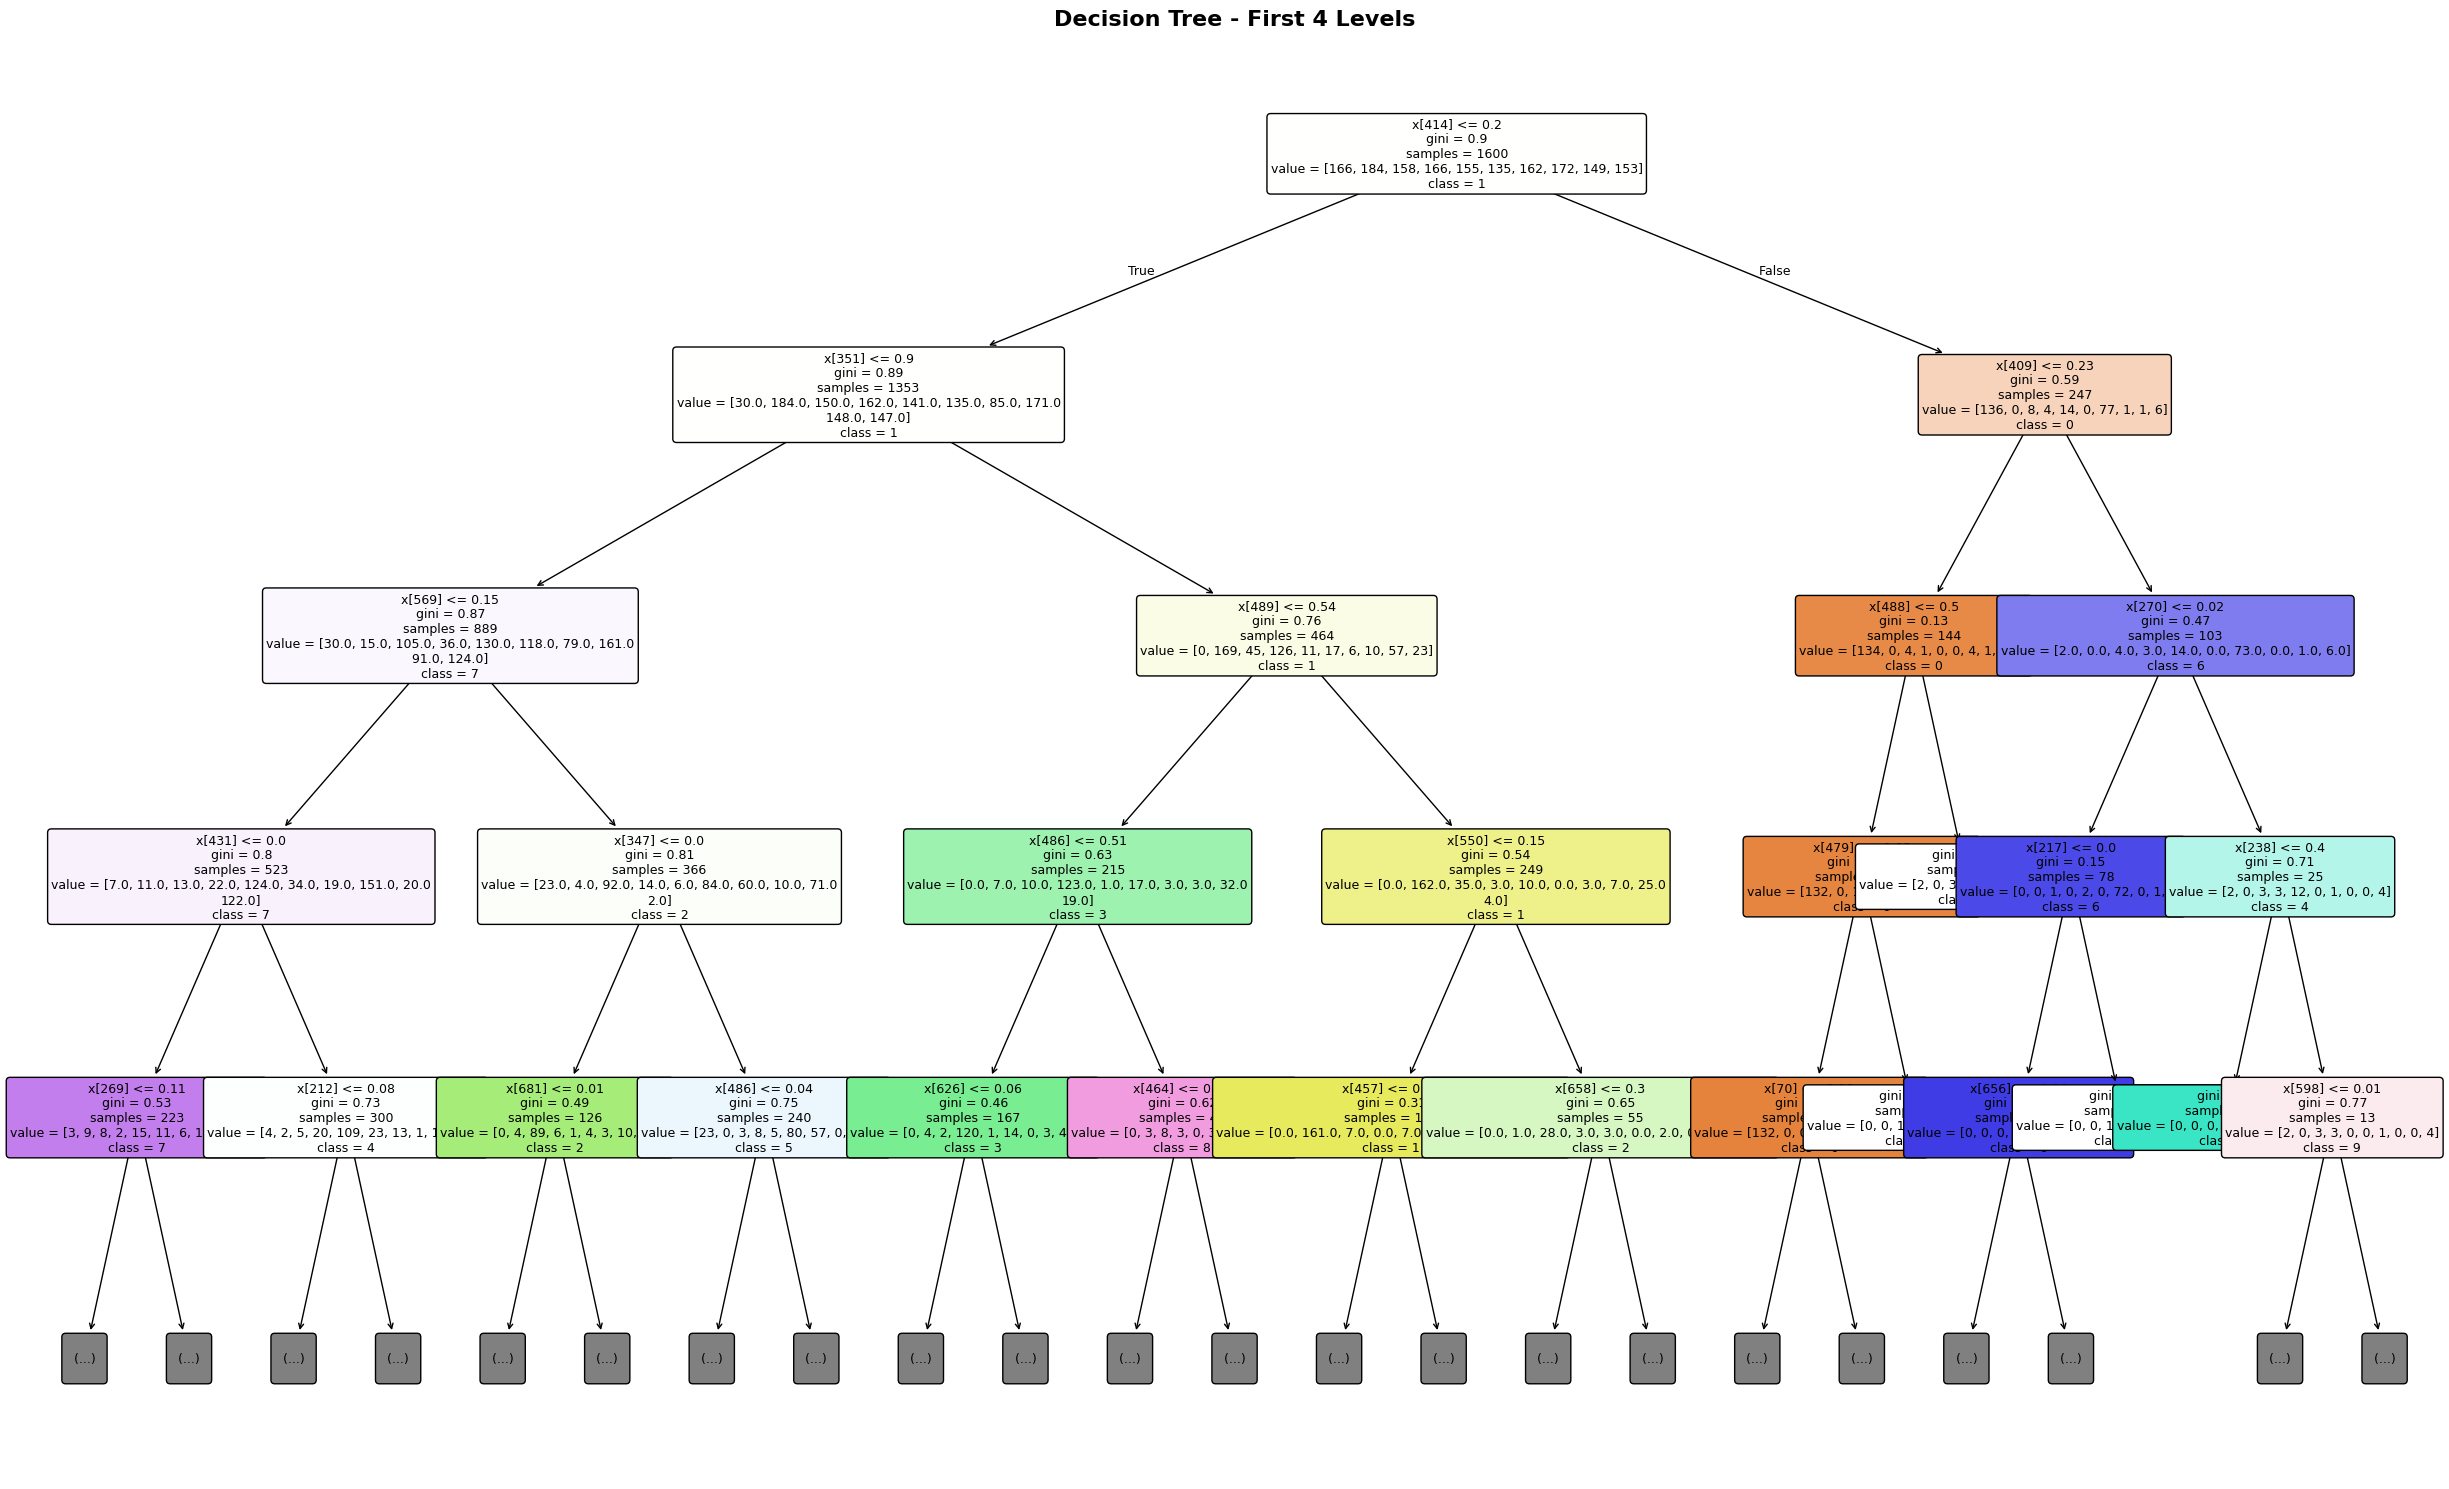

In [22]:
# Visualizing the tree
# Best for initial visualization
plt.figure(figsize=(25, 15))
plot_tree(dt, 
          max_depth=4,              # Good balance between detail and readability
          class_names=[str(i) for i in range(10)],
          filled=True,
          rounded=True,
          fontsize=9,
          precision=2)
plt.title("Decision Tree - First 4 Levels", fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

#---------------------------------------------------------------------
# 5. RANDOM FOREST

In [23]:
print("  Algorithm: Random Forest (Ensemble of Decision Trees)")
print("\nTraining Random Forest classifier...")
print("  Parameters: n_estimators=100, max_depth=20, random_state=42")

rf_train_start_time = time.time()
random_forest = RandomForestClassifier(n_estimators=100, max_depth=20, 
                            random_state=42, n_jobs=-1)
random_forest.fit(X_train_normalized, y_train)
rf_train_time = time.time() - rf_train_start_time

print(f"✓ Training completed in {rf_train_time:.4f} seconds")

  Algorithm: Random Forest (Ensemble of Decision Trees)

Training Random Forest classifier...
  Parameters: n_estimators=100, max_depth=20, random_state=42
✓ Training completed in 0.2272 seconds


In [24]:
#Making predictions 
rf_pred_start_time = time.time()
y_pred_rf = random_forest.predict(X_test_normalized)
rf_pred_time = time.time() - rf_pred_start_time

print(f"✓ Predictions completed in {rf_pred_time:.4f} seconds")

✓ Predictions completed in 0.0342 seconds


In [25]:
# Evaluate Model
random_forest_metrics = evaluate_model(y_test, y_pred_rf, "Random Forest")

# Store results
results_without_pca.append({
    'Classifier': 'Random Forest',
    'Accuracy': random_forest_metrics[0],
    'Precision': random_forest_metrics[1],
    'Recall': random_forest_metrics[2],
    'F1-Score': random_forest_metrics[3],
    'Train Time (s)': rf_train_time,
    'Predict Time (s)': rf_pred_time
})


Random Forest - Performance Metrics:
  Accuracy:  0.9425 (94.25%)
  Precision: 0.9425
  Recall:    0.9425
  F1-Score:  0.9425


Visualizing Random Forest Trees...
Total trees in forest: 100
Plotting first tree as examples



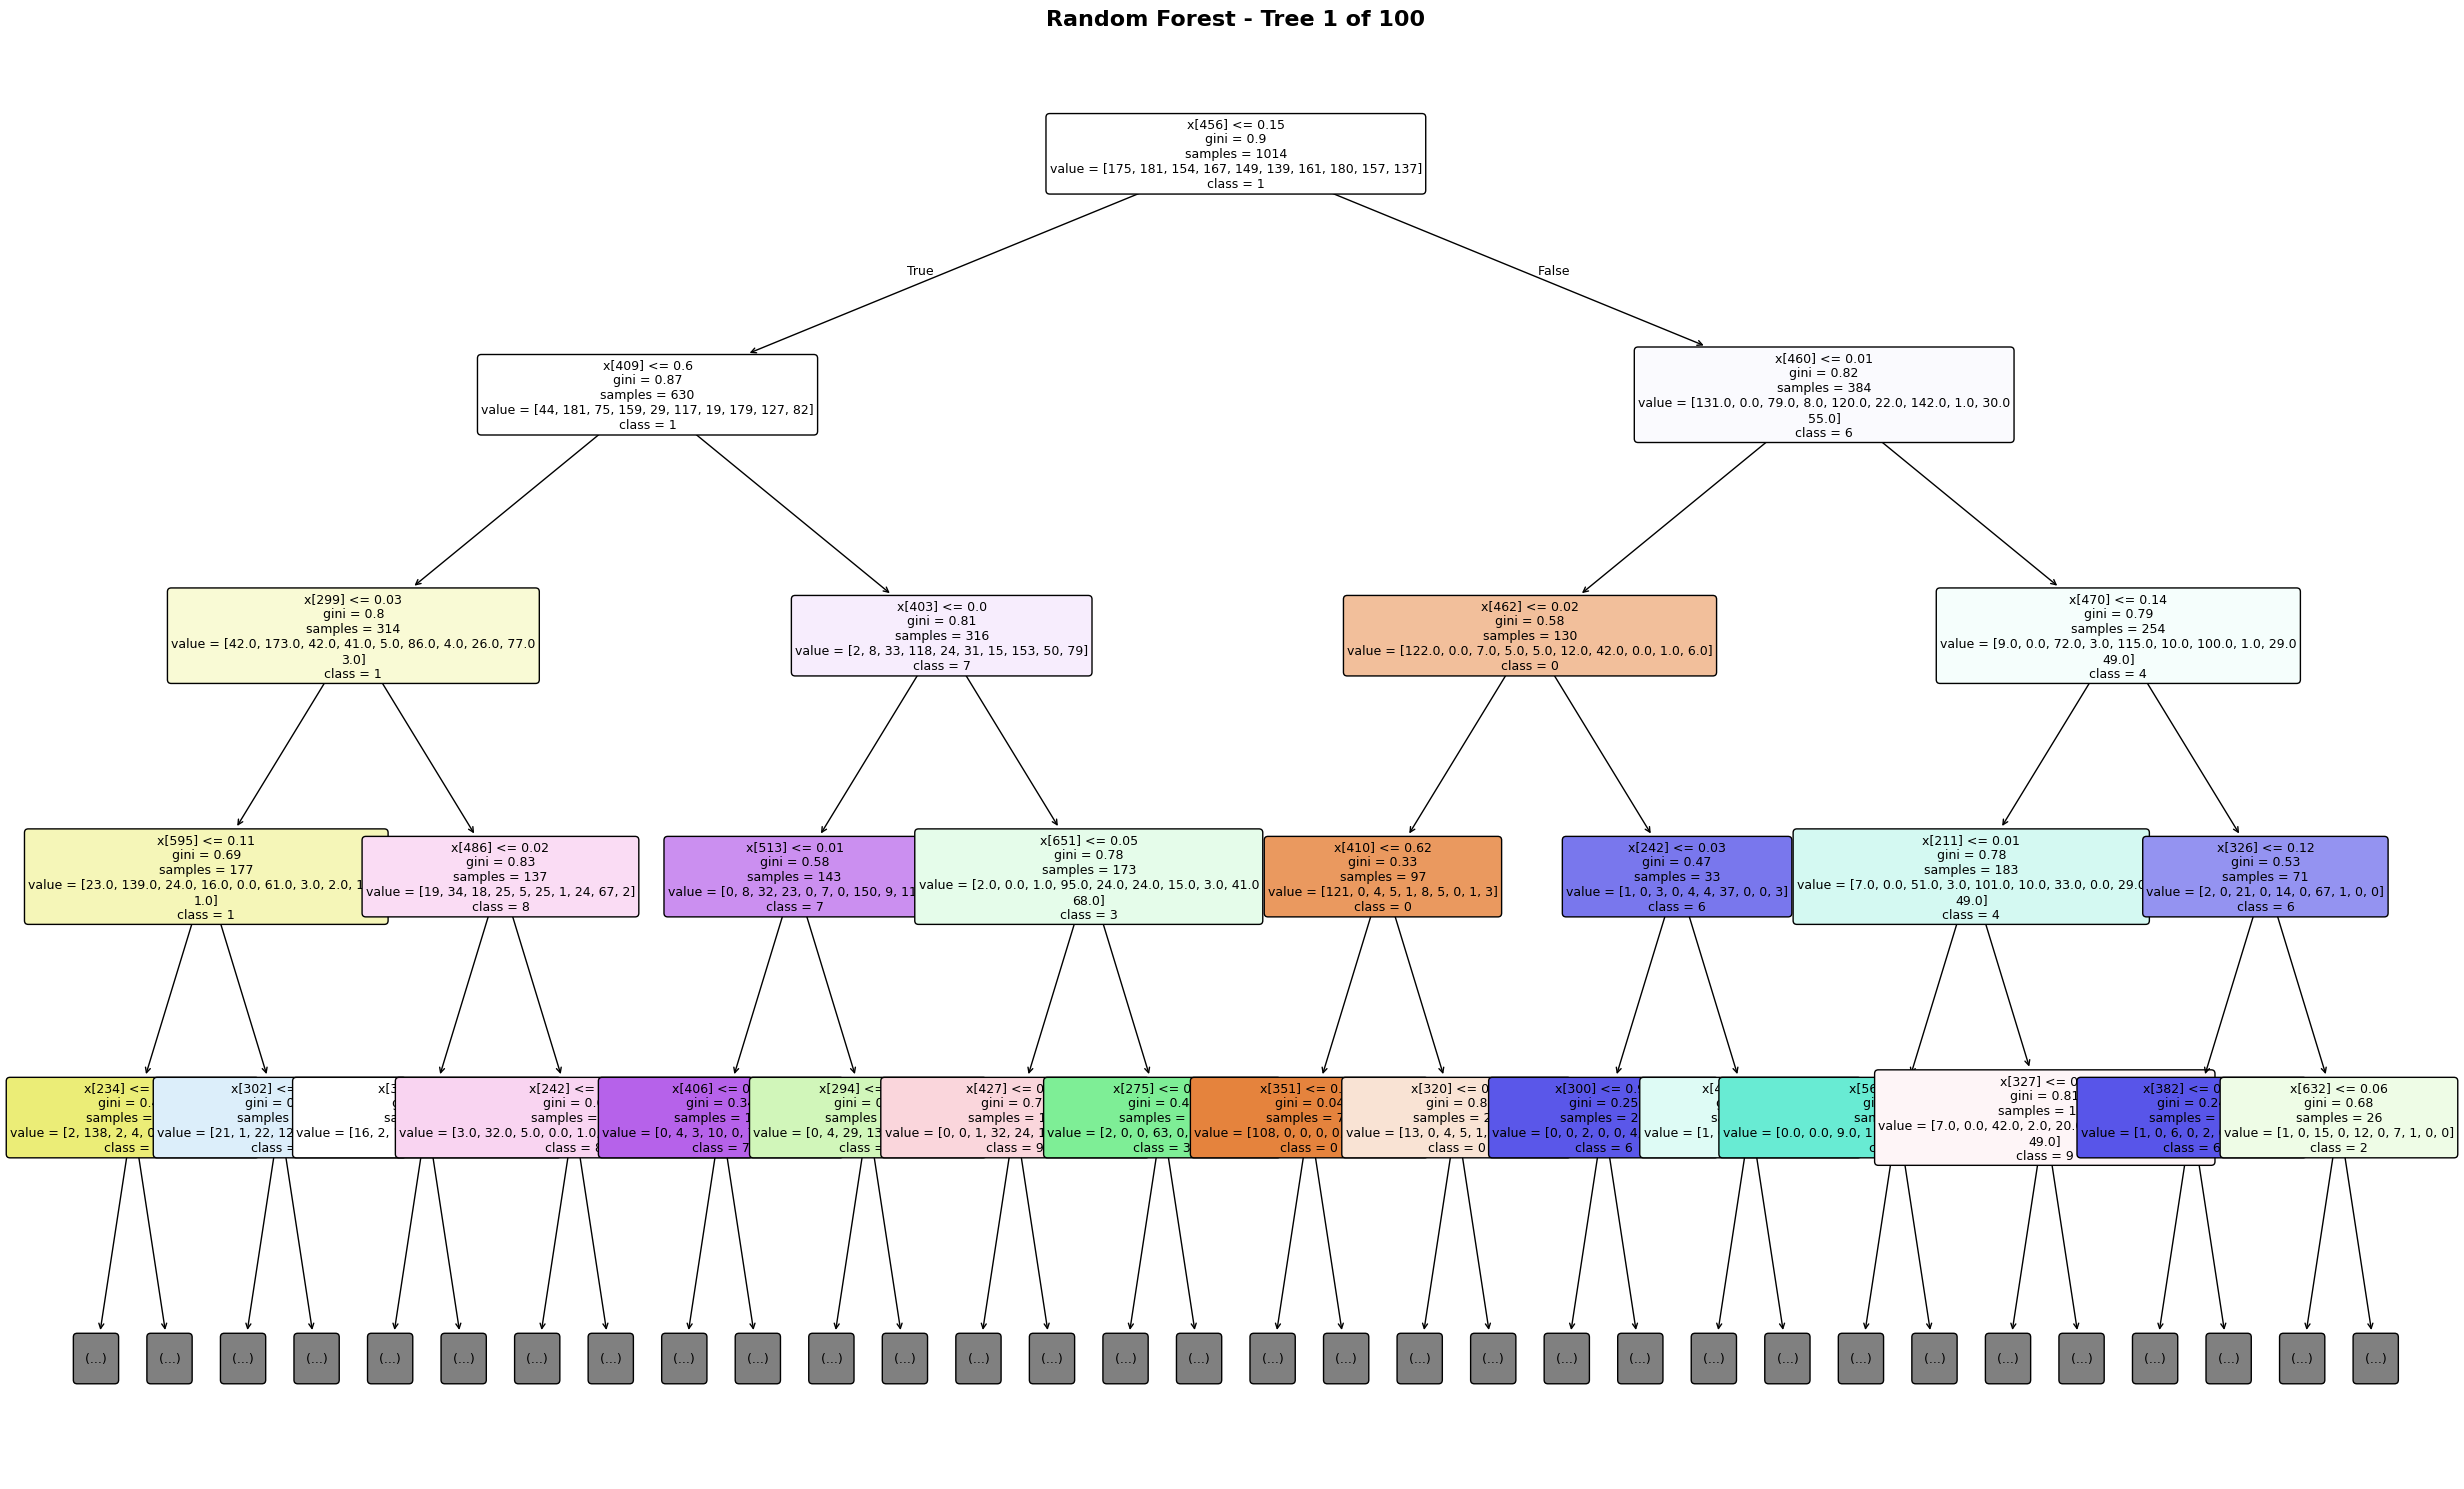

✓ Tree 1 visualized

Note: Random Forest contains 100 trees total.
Each tree is trained on a different bootstrap sample of the data.


In [26]:
# Visualize Random Forest Trees
print("Visualizing Random Forest Trees...")
print(f"Total trees in forest: {len(random_forest.estimators_)}")
print(f"Plotting first tree as examples\n")

# Plot first 3 trees from the Random Forest
num_trees_to_plot = 1
class_names = [str(i) for i in range(10)]  # Digits 0-9 for MNIST

for i in range(min(num_trees_to_plot, len(random_forest.estimators_))):
    plt.figure(figsize=(25, 15))
    plot_tree(random_forest.estimators_[i],
              max_depth=4,              # Limit depth for readability
              class_names=class_names,
              filled=True,              # Color nodes by class
              rounded=True,             # Rounded boxes
              fontsize=9,               # Font size
              precision=2)              # Decimal precision
    plt.title(f"Random Forest - Tree {i+1} of {len(random_forest.estimators_)}", 
              fontsize=16, fontweight='bold')
    plt.tight_layout()
    plt.show()
    print(f"✓ Tree {i+1} visualized\n")

print(f"Note: Random Forest contains {len(random_forest.estimators_)} trees total.")
print("Each tree is trained on a different bootstrap sample of the data.")

#---------------------------------------------------------------------
# 6. NAIVE BAYES

In [27]:
print("  Algorithm: Gaussian Naive Bayes")
print("\nTraining Gaussian Naive Bayes classifier...")

nb_train_start_time = time.time()
nb = GaussianNB()
nb.fit(X_train_normalized, y_train)
nb_train_time = time.time() - nb_train_start_time 

print(f"✓ Training completed in {nb_train_time:.4f} seconds")

  Algorithm: Gaussian Naive Bayes

Training Gaussian Naive Bayes classifier...
✓ Training completed in 0.0436 seconds


In [28]:
# Making Predictions 
nb_pred_start_time = time.time()
y_pred_nb = nb.predict(X_test_normalized)
nb_pred_time = time.time() - nb_pred_start_time

print(f"✓ Predictions completed in {nb_pred_time:.4f} seconds")

✓ Predictions completed in 0.0926 seconds


In [29]:
# Evaluate Model 
nb_metrics = evaluate_model(y_test, y_pred_nb, "Naive Bayes")

# Store results
results_without_pca.append({
    'Classifier': 'Naive Bayes',
    'Accuracy': nb_metrics[0],
    'Precision': nb_metrics[1],
    'Recall': nb_metrics[2],
    'F1-Score': nb_metrics[3],
    'Train Time (s)': nb_train_time,
    'Predict Time (s)': nb_pred_time
})


Naive Bayes - Performance Metrics:
  Accuracy:  0.7200 (72.00%)
  Precision: 0.7200
  Recall:    0.7200
  F1-Score:  0.7200


PRINT THE SUMMARY TABLE WITHOUT PCA

In [30]:
print("\n" + "="*96)
print("RESULTS SUMMARY - WITHOUT PCA")
print()

# Create DataFrame for better visualization
df_results_no_pca = pd.DataFrame(results_without_pca)

# Display table
print(df_results_no_pca.to_string(index=False))
print()

# Find best performer
best_accuracy_idx = df_results_no_pca['Accuracy'].idxmax()
fastest_train_idx = df_results_no_pca['Train Time (s)'].idxmin()
fastest_pred_idx = df_results_no_pca['Predict Time (s)'].idxmin()

print("\n📊 Key Insights:")
print(f"  🏆 Best Accuracy: {df_results_no_pca.loc[best_accuracy_idx, 'Classifier']} "
      f"({df_results_no_pca.loc[best_accuracy_idx, 'Accuracy']:.4f})")
print(f"  ⚡ Fastest Training: {df_results_no_pca.loc[fastest_train_idx, 'Classifier']} "
      f"({df_results_no_pca.loc[fastest_train_idx, 'Train Time (s)']:.4f}s)")
print(f"  🚀 Fastest Prediction: {df_results_no_pca.loc[fastest_pred_idx, 'Classifier']} "
      f"({df_results_no_pca.loc[fastest_pred_idx, 'Predict Time (s)']:.4f}s)")

print("\n" + "="*96)
print()
print()


RESULTS SUMMARY - WITHOUT PCA

             Classifier  Accuracy  Precision  Recall  F1-Score  Train Time (s)  Predict Time (s)
    Logistic Regression    0.9350     0.9350  0.9350    0.9350        9.505056          0.005948
     K Nearest Neigbors    0.9450     0.9450  0.9450    0.9450        0.005881          3.091135
Support Vector Machines    0.9675     0.9675  0.9675    0.9675        0.271566          0.133779
         Decision Trees    0.7500     0.7500  0.7500    0.7500        0.186109          0.002781
          Random Forest    0.9425     0.9425  0.9425    0.9425        0.227169          0.034196
            Naive Bayes    0.7200     0.7200  0.7200    0.7200        0.043561          0.092582


📊 Key Insights:
  🏆 Best Accuracy: Support Vector Machines (0.9675)
  ⚡ Fastest Training: K Nearest Neigbors (0.0059s)
  🚀 Fastest Prediction: Decision Trees (0.0028s)





#-------------------------------------------------------------------------

SECTION 3 PCA ON EACH CLASSIFICATION ALGORITHMS

#-------------------------------------------------------------------------

In [31]:
print("Performing PCA analysis...")
print("  Analyzing explained variance for different component counts...")
print()

Performing PCA analysis...
  Analyzing explained variance for different component counts...



In [32]:
# Apply PCA with different components
pca = PCA(n_components=0.95, random_state=42)  # Keep 95% variance
X_train_pca = pca.fit_transform(X_train_normalized)
X_test_pca = pca.transform(X_test_normalized) 


In [33]:
n_components = pca.n_components_
explained_variance = pca.explained_variance_ratio_.sum()

print(f"✓ PCA Analysis Complete")
print(f"  Components needed for 95% variance: {n_components}")
print(f"  Actual explained variance: {explained_variance:.4f} ({explained_variance*100:.2f}%)")
print(f"  Original dimensions: {X_train_normalized.shape[1]}")
print(f"  Reduced dimensions: {X_train_pca.shape[1]}")
print(f"  Dimensionality reduction: {(1 - n_components/X_train_normalized.shape[1])*100:.1f}%")
print()


✓ PCA Analysis Complete
  Components needed for 95% variance: 131
  Actual explained variance: 0.9502 (95.02%)
  Original dimensions: 784
  Reduced dimensions: 131
  Dimensionality reduction: 83.3%



In [34]:
# Dictionary to store PCA results
results_with_pca = []

#--------------------------------------------------------------------------
# 1. LOGISTIC REGRESSION WITH PCA

In [35]:
print(f"\nTraining Logistic Regression with {n_components} PCA components...")

lr_pca_start_time = time.time()
log_reg_pca = LogisticRegression(max_iter=2000, solver='lbfgs', 
                                  multi_class='multinomial', random_state=42, n_jobs=-1)
log_reg_pca.fit(X_train_pca, y_train)
lr_pca_train_time = time.time() - lr_pca_start_time

print(f"✓ Training completed in {lr_pca_train_time:.4f} seconds")
print(f"  Speedup vs no PCA: {lr_train_time/lr_pca_train_time:.2f}x faster")


Training Logistic Regression with 131 PCA components...
✓ Training completed in 4.9308 seconds
  Speedup vs no PCA: 1.93x faster


In [36]:
# Make Predictions 
start_time_pred_lr_pca = time.time()
y_pred_lr_pca = log_reg_pca.predict(X_test_pca)
lr_pca_pred_time = time.time() - start_time_pred_lr_pca

print(f"✓ Predictions completed in {lr_pca_pred_time:.4f} seconds")

✓ Predictions completed in 0.0005 seconds


In [37]:
# Evaluate
lr_pca_metrics = evaluate_model(y_test, y_pred_lr_pca, "Logistic Regression (PCA)")

# Store results
results_with_pca.append({
    'Classifier': 'Logistic Regression',
    'Accuracy': lr_pca_metrics[0],
    'Precision': lr_pca_metrics[1],
    'Recall': lr_pca_metrics[2],
    'F1-Score': lr_pca_metrics[3],
    'Train Time (s)': lr_pca_train_time,
    'Predict Time (s)': lr_pca_pred_time,
    'Accuracy Change': lr_pca_metrics[0] - lr_metrics[0],
    'Speed Improvement': lr_train_time / lr_pca_train_time
}) 


Logistic Regression (PCA) - Performance Metrics:
  Accuracy:  0.9375 (93.75%)
  Precision: 0.9375
  Recall:    0.9375
  F1-Score:  0.9375


#--------------------------------------------------------------------------
# 2. K NEAREST NEIGBORS WITH PCA

In [38]:
print(f"\nTraining KNN with {n_components} PCA components...")

start_time_knn_pca = time.time()
knn_pca = KNeighborsClassifier(n_neighbors=5, weights='uniform', n_jobs=-1)
knn_pca.fit(X_train_pca, y_train)
knn_pca_train_time = time.time() - start_time_knn_pca

print(f"✓ Training completed in {knn_pca_train_time:.4f} seconds")


Training KNN with 131 PCA components...
✓ Training completed in 0.0027 seconds


In [39]:
print("\nMaking predictions...")
start_time_pred_knn_pca = time.time()
y_pred_knn_pca = knn_pca.predict(X_test_pca)
knn_pca_pred_time = time.time() - start_time_pred_knn_pca

print(f"✓ Predictions completed in {knn_pca_pred_time:.4f} seconds")
print(f"  Speedup vs no PCA: {knn_pred_time/knn_pca_pred_time:.2f}x faster")


Making predictions...
✓ Predictions completed in 0.0078 seconds
  Speedup vs no PCA: 397.20x faster


In [40]:
# Evaluate
knn_pca_metrics = evaluate_model(y_test, y_pred_knn_pca, "KNN (PCA)")

# Store results
results_with_pca.append({
    'Classifier': 'K Nearest Neighbors',
    'Accuracy': knn_pca_metrics[0],
    'Precision': knn_pca_metrics[1],
    'Recall': knn_pca_metrics[2],
    'F1-Score': knn_pca_metrics[3],
    'Train Time (s)': knn_pca_train_time,
    'Predict Time (s)': knn_pca_pred_time,
    'Accuracy Change': knn_pca_metrics[0] - knn_metrics[0],
    'Speed Improvement': knn_pred_time / knn_pca_pred_time
})


KNN (PCA) - Performance Metrics:
  Accuracy:  0.9525 (95.25%)
  Precision: 0.9525
  Recall:    0.9525
  F1-Score:  0.9525


#--------------------------------------------------------------------------
# 3. SVM WITH PCA

In [41]:
print(f"\nTraining SVM with {n_components} PCA components...")

start_time_svm_pca = time.time()
svm_pca = SVC(kernel='rbf', C=5, gamma='scale', random_state=42)
svm_pca.fit(X_train_pca, y_train)
svm_pca_train_time = time.time() - start_time_svm_pca

print(f"✓ Training completed in {svm_pca_train_time:.4f} seconds")
print(f"  Speedup vs no PCA: {svm_train_time/svm_pca_train_time:.2f}x faster ⚡")


Training SVM with 131 PCA components...
✓ Training completed in 0.0989 seconds
  Speedup vs no PCA: 2.75x faster ⚡


In [42]:
print("\nMaking predictions...")
start_time_pred_svm_pca = time.time()
y_pred_svm_pca = svm_pca.predict(X_test_pca)
svm_pca_pred_time = time.time() - start_time_pred_svm_pca

print(f"✓ Predictions completed in {svm_pca_pred_time:.4f} seconds")



Making predictions...
✓ Predictions completed in 0.0391 seconds


In [43]:
# Evaluate
svm_pca_metrics = evaluate_model(y_test, y_pred_svm_pca, "SVM (PCA)")

# Store results
results_with_pca.append({
    'Classifier': 'Support Vector Machines',
    'Accuracy': svm_pca_metrics[0],
    'Precision': svm_pca_metrics[1],
    'Recall': svm_pca_metrics[2],
    'F1-Score': svm_pca_metrics[3],
    'Train Time (s)': svm_pca_train_time,
    'Predict Time (s)': svm_pca_pred_time,
    'Accuracy Change': svm_pca_metrics[0] - svm_metrics[0],
    'Speed Improvement': svm_train_time / svm_pca_train_time
})


SVM (PCA) - Performance Metrics:
  Accuracy:  0.9700 (97.00%)
  Precision: 0.9700
  Recall:    0.9700
  F1-Score:  0.9700


#--------------------------------------------------------------------------
# 4. DECISION TREES WITH PCA

In [44]:
print(f"\nTraining DECISION TREES with {n_components} PCA components...")
print("  Parameters: max_depth=20, min_samples_split=10, criterion='gini'")
print("\nTraining Decision Tree classifier...")

dt_pca_start_time = time.time()
dt_pca = DecisionTreeClassifier(max_depth=20, min_samples_split=10, 
                            criterion='gini', random_state=42)
dt_pca.fit(X_train_pca, y_train)
dt_pca_train_time = time.time() - dt_pca_start_time

print(f"✓ Training completed in {dt_pca_train_time:.4f} seconds")


Training DECISION TREES with 131 PCA components...
  Parameters: max_depth=20, min_samples_split=10, criterion='gini'

Training Decision Tree classifier...
✓ Training completed in 0.2350 seconds


In [45]:
# Making predictions 
dt_pca_pred_start_time = time.time()
y_pred_dt_pca = dt_pca.predict(X_test_pca)
dt_pca_pred_time = time.time() - dt_pca_pred_start_time

print(f"✓ Predictions completed in {dt_pred_time:.4f} seconds")

✓ Predictions completed in 0.0028 seconds


In [46]:
# Evaluate
dt_pca_metrics = evaluate_model(y_test, y_pred_dt_pca, "DT (PCA)")

# Store results
results_with_pca.append({
    'Classifier': 'Decision Trees',
    'Accuracy': dt_pca_metrics[0],
    'Precision': dt_pca_metrics[1],
    'Recall': dt_pca_metrics[2],
    'F1-Score': dt_pca_metrics[3],
    'Train Time (s)': dt_pca_train_time,
    'Predict Time (s)': dt_pca_pred_time,
    'Accuracy Change': dt_pca_metrics[0] - dt_metrics[0],
    'Speed Improvement': dt_train_time / dt_pca_train_time
})


DT (PCA) - Performance Metrics:
  Accuracy:  0.7425 (74.25%)
  Precision: 0.7425
  Recall:    0.7425
  F1-Score:  0.7425


#--------------------------------------------------------------------------
# 5. RANDOM FOREST WITH PCA

In [47]:
print(f"\nTraining Random Forest with {n_components} PCA components...")

start_time_rf_pca = time.time()
rf_pca = RandomForestClassifier(n_estimators=100, max_depth=20, 
                                random_state=42, n_jobs=-1)
rf_pca.fit(X_train_pca, y_train)
rf_pca_train_time = time.time() - start_time_rf_pca

print(f"✓ Training completed in {rf_pca_train_time:.4f} seconds")
print(f"  Speedup vs no PCA: {rf_train_time/rf_pca_train_time:.2f}x faster")


Training Random Forest with 131 PCA components...
✓ Training completed in 0.3282 seconds
  Speedup vs no PCA: 0.69x faster


In [48]:
print("\nMaking predictions...")
start_time_pred_rf_pca = time.time()
y_pred_rf_pca = rf_pca.predict(X_test_pca)
rf_pca_pred_time = time.time() - start_time_pred_rf_pca

print(f"✓ Predictions completed in {rf_pca_pred_time:.4f} seconds")


Making predictions...
✓ Predictions completed in 0.0325 seconds


In [49]:
# Evaluate
rf_pca_metrics = evaluate_model(y_test, y_pred_rf_pca, "Random Forest (PCA)")

# Store results
results_with_pca.append({
    'Classifier': 'Random Forest',
    'Accuracy': rf_pca_metrics[0],
    'Precision': rf_pca_metrics[1],
    'Recall': rf_pca_metrics[2],
    'F1-Score': rf_pca_metrics[3],
    'Train Time (s)': rf_pca_train_time,
    'Predict Time (s)': rf_pca_pred_time,
    'Accuracy Change': rf_pca_metrics[0] - random_forest_metrics[0],
    'Speed Improvement': rf_train_time / rf_pca_train_time
})


Random Forest (PCA) - Performance Metrics:
  Accuracy:  0.9175 (91.75%)
  Precision: 0.9175
  Recall:    0.9175
  F1-Score:  0.9175


#--------------------------------------------------------------------------
# 6. NAIVE BAYES WITH PCA

In [50]:
print(f"\nTraining Naive Bayes with {n_components} PCA components...")
print("  Expected: Minimal impact (already very fast)")

start_time_nb_pca = time.time()
nb_pca = GaussianNB()
nb_pca.fit(X_train_pca, y_train)
nb_pca_train_time = time.time() - start_time_nb_pca

print(f"✓ Training completed in {nb_pca_train_time:.4f} seconds")


Training Naive Bayes with 131 PCA components...
  Expected: Minimal impact (already very fast)
✓ Training completed in 0.0062 seconds


In [51]:
print("\nMaking predictions...")
start_time_pred_nb_pca = time.time()
y_pred_nb_pca = nb_pca.predict(X_test_pca)
nb_pca_pred_time = time.time() - start_time_pred_nb_pca

print(f"✓ Predictions completed in {nb_pca_pred_time:.4f} seconds")


Making predictions...
✓ Predictions completed in 0.0025 seconds


In [52]:
# Evaluate
nb_pca_metrics = evaluate_model(y_test, y_pred_nb_pca, "Naive Bayes (PCA)")

# Store results
results_with_pca.append({
    'Classifier': 'Naive Bayes',
    'Accuracy': nb_pca_metrics[0],
    'Precision': nb_pca_metrics[1],
    'Recall': nb_pca_metrics[2],
    'F1-Score': nb_pca_metrics[3],
    'Train Time (s)': nb_pca_train_time,
    'Predict Time (s)': nb_pca_pred_time,
    'Accuracy Change': nb_pca_metrics[0] - nb_metrics[0],
    'Speed Improvement': nb_train_time / nb_pca_train_time if nb_pca_train_time > 0 else 1.0
})


Naive Bayes (PCA) - Performance Metrics:
  Accuracy:  0.8700 (87.00%)
  Precision: 0.8700
  Recall:    0.8700
  F1-Score:  0.8700


SUMMARY TABLE WITH PCA

In [58]:
#SUMMARY TABLE WITH PCA
# Create DataFrame for PCA results
df_results_pca = pd.DataFrame(results_with_pca)

# Display main metrics
print("Performance Metrics With PCA:")
print(df_results_pca[['Classifier', 'Accuracy', 'Precision', 'Recall', 
                       'F1-Score', 'Train Time (s)', 'Predict Time (s)']].to_string(index=False))
print()

# Display changes
print("\nImpact of PCA:")
print(df_results_pca[['Classifier', 'Accuracy Change', 'Speed Improvement']].to_string(index=False))
print()

# Find best performer
best_accuracy_idx = df_results_pca['Accuracy'].idxmax()
best_speedup_idx = df_results_pca['Speed Improvement'].idxmax()

print("\n📊 Key Insights with PCA:")
print(f"  🏆 Best Accuracy: {df_results_pca.loc[best_accuracy_idx, 'Classifier']} "
      f"({df_results_pca.loc[best_accuracy_idx, 'Accuracy']:.4f})")
print(f"  ⚡ Best Speed Improvement: {df_results_pca.loc[best_speedup_idx, 'Classifier']} "
      f"({df_results_pca.loc[best_speedup_idx, 'Speed Improvement']:.2f}x faster)")

print("\n" + "="*80)
print()
print()

Performance Metrics With PCA:
             Classifier  Accuracy  Precision  Recall  F1-Score  Train Time (s)  Predict Time (s)
    Logistic Regression    0.9375     0.9375  0.9375    0.9375        4.930840          0.000514
    K Nearest Neighbors    0.9525     0.9525  0.9525    0.9525        0.002657          0.007782
Support Vector Machines    0.9700     0.9700  0.9700    0.9700        0.098861          0.039091
         Decision Trees    0.7425     0.7425  0.7425    0.7425        0.234973          0.000909
          Random Forest    0.9175     0.9175  0.9175    0.9175        0.328224          0.032460
            Naive Bayes    0.8700     0.8700  0.8700    0.8700        0.006224          0.002516


Impact of PCA:
             Classifier  Accuracy Change  Speed Improvement
    Logistic Regression           0.0025           1.927675
    K Nearest Neighbors           0.0075         397.204773
Support Vector Machines           0.0025           2.746961
         Decision Trees          -

# ============================================================================
# FINAL COMPARISON: PCA IMPACT ANALYSIS

In [59]:
print(f"PCA Configuration:")
print(f"  Components used: {n_components}")
print(f"  Explained variance: {explained_variance*100:.2f}%")
print(f"  Dimension reduction: 784 → {n_components} ({(1-n_components/784)*100:.1f}% reduction)")
print()

PCA Configuration:
  Components used: 131
  Explained variance: 95.02%
  Dimension reduction: 784 → 131 (83.3% reduction)



In [60]:
# Create comprehensive comparison
comparison_data = []
for i, classifier in enumerate(['Logistic Regression', 'K Nearest Neighbors', 'Support Vector Machines', 'Decision Trees', 'Random Forest', 'Naive Bayes']):
    comparison_data.append({
        'Classifier': classifier,
        'Accuracy (No PCA)': results_without_pca[i]['Accuracy'],
        'Accuracy (With PCA)': results_with_pca[i]['Accuracy'],
        'Δ Accuracy': results_with_pca[i]['Accuracy Change'],
        'Train Time (No PCA)': results_without_pca[i]['Train Time (s)'],
        'Train Time (With PCA)': results_with_pca[i]['Train Time (s)'],
        'Training Speedup': results_with_pca[i]['Speed Improvement']
    })

df_comparison = pd.DataFrame(comparison_data)

print("\n" + "="*80)
print("COMPREHENSIVE COMPARISON TABLE")
print("="*80)
print()
print(df_comparison.to_string(index=False))
print()


COMPREHENSIVE COMPARISON TABLE

             Classifier  Accuracy (No PCA)  Accuracy (With PCA)  Δ Accuracy  Train Time (No PCA)  Train Time (With PCA)  Training Speedup
    Logistic Regression             0.9350               0.9375      0.0025             9.505056               4.930840          1.927675
    K Nearest Neighbors             0.9450               0.9525      0.0075             0.005881               0.002657        397.204773
Support Vector Machines             0.9675               0.9700      0.0025             0.271566               0.098861          2.746961
         Decision Trees             0.7500               0.7425     -0.0075             0.186109               0.234973          0.792044
          Random Forest             0.9425               0.9175     -0.0250             0.227169               0.328224          0.692114
            Naive Bayes             0.7200               0.8700      0.1500             0.043561               0.006224          6.999310



In [61]:

df_results_pca = pd.DataFrame(results_with_pca)

DETAILED IMPACT ANALYSIS

In [67]:
#DETAILED IMPACT ANALYSIS
print(" DETAILED IMPACT ANALYSIS")
print("1️⃣  ACCURACY IMPACT:")
print("-" * 60)
for i, row in df_comparison.iterrows():
    classifier = row['Classifier']
    delta = row['Δ Accuracy']
    if delta > 0.01:
        impact = f"↑ IMPROVED by {abs(delta):.4f}"
        emoji = "✅"
    elif delta < -0.01:
        impact = f"↓ DECREASED by {abs(delta):.4f}"
        emoji = "⚠️"
    else:
        impact = f"≈ MINIMAL CHANGE ({delta:+.4f})"
        emoji = "➡️"
    
    print(f"  {emoji} {classifier:20s}: {impact}")
print()

print("2️⃣  SPEED IMPACT (Training):")
print("-" * 60)
for i, row in df_comparison.iterrows():
    classifier = row['Classifier']
    speedup = row['Training Speedup']
    if speedup > 2:
        print(f"  🚀 {classifier:20s}: {speedup:.2f}x FASTER (Significant improvement)")
    elif speedup > 1.2:
        print(f"  ⚡ {classifier:20s}: {speedup:.2f}x faster (Moderate improvement)")
    elif speedup > 0.9:
        print(f"  ➡️  {classifier:20s}: {speedup:.2f}x (Minimal change)")
    else:
        print(f"  🐌 {classifier:20s}: {speedup:.2f}x (Slightly slower)")
print()


 DETAILED IMPACT ANALYSIS
1️⃣  ACCURACY IMPACT:
------------------------------------------------------------
  ➡️ Logistic Regression : ≈ MINIMAL CHANGE (+0.0025)
  ➡️ K Nearest Neighbors : ≈ MINIMAL CHANGE (+0.0075)
  ➡️ Support Vector Machines: ≈ MINIMAL CHANGE (+0.0025)
  ➡️ Decision Trees      : ≈ MINIMAL CHANGE (-0.0075)
  ⚠️ Random Forest       : ↓ DECREASED by 0.0250
  ✅ Naive Bayes         : ↑ IMPROVED by 0.1500

2️⃣  SPEED IMPACT (Training):
------------------------------------------------------------
  ⚡ Logistic Regression : 1.93x faster (Moderate improvement)
  🚀 K Nearest Neighbors : 397.20x FASTER (Significant improvement)
  🚀 Support Vector Machines: 2.75x FASTER (Significant improvement)
  🐌 Decision Trees      : 0.79x (Slightly slower)
  🐌 Random Forest       : 0.69x (Slightly slower)
  🚀 Naive Bayes         : 7.00x FASTER (Significant improvement)



OVERALL ASSESSMENT

In [69]:
# Calculate overall winners
best_without_pca = df_results_no_pca.loc[df_results_no_pca['Accuracy'].idxmax()]
best_with_pca = df_results_pca.loc[df_results_pca['Accuracy'].idxmax()]
fastest_with_pca = df_results_pca.loc[df_results_pca['Train Time (s)'].idxmin()]

print(f"\n  OVERALL ASSESSMENT")
print("-" * 60)
print(f"  Without PCA:")
print(f"    • Best performer: {best_without_pca['Classifier']}")
print(f"    • Accuracy: {best_without_pca['Accuracy']:.4f}")
print(f"    • Training time: {best_without_pca['Train Time (s)']:.4f}s")

print(f"\n  With PCA:")
print(f"    • Best performer: {best_with_pca['Classifier']}")
print(f"    • Accuracy: {best_with_pca['Accuracy']:.4f}")
print(f"    • Training time: {best_with_pca['Train Time (s)']:.4f}s")

print(f"\n  Fastest with PCA:")
print(f"    • {fastest_with_pca['Classifier']}")
print(f"    • Training time: {fastest_with_pca['Train Time (s)']:.6f}s")
print()


  OVERALL ASSESSMENT
------------------------------------------------------------
  Without PCA:
    • Best performer: Support Vector Machines
    • Accuracy: 0.9675
    • Training time: 0.2716s

  With PCA:
    • Best performer: Support Vector Machines
    • Accuracy: 0.9700
    • Training time: 0.0989s

  Fastest with PCA:
    • K Nearest Neighbors
    • Training time: 0.002657s



KEY FINDINGS

In [64]:
print("4️⃣  KEY FINDINGS:")
print("-" * 60)

# Identify classifiers that benefit most from PCA
speedup_sorted = df_comparison.sort_values('Training Speedup', ascending=False)
most_benefited = speedup_sorted.iloc[0]
least_benefited = speedup_sorted.iloc[-1]

print(f"\n  ✨ Most benefited from PCA: {most_benefited['Classifier']}")
print(f"     • Speed improvement: {most_benefited['Training Speedup']:.2f}x")
print(f"     • Accuracy change: {most_benefited['Δ Accuracy']:+.4f}")
print(f"     • Recommendation: STRONGLY RECOMMENDED for production use")

print(f"\n  🔍 Least benefited from PCA: {least_benefited['Classifier']}")
print(f"     • Speed improvement: {least_benefited['Training Speedup']:.2f}x")
print(f"     • Accuracy change: {least_benefited['Δ Accuracy']:+.4f}")

4️⃣  KEY FINDINGS:
------------------------------------------------------------

  ✨ Most benefited from PCA: K Nearest Neighbors
     • Speed improvement: 397.20x
     • Accuracy change: +0.0075
     • Recommendation: STRONGLY RECOMMENDED for production use

  🔍 Least benefited from PCA: Random Forest
     • Speed improvement: 0.69x
     • Accuracy change: -0.0250


SUMMARY STATISTICS

In [70]:
print("📝 Summary Statistics:")
print("-" * 60)
print(f"  • Total models trained: 12 (6 without PCA + 6 with PCA)")
print(f"  • PCA components used: {n_components} (from 784 original features)")
print(f"  • Dataset: 2000 samples (1600 train, 400 test)")
print(f"  • Classes: 10 digits (0-9)")
print(f"  • Best overall accuracy: {max(df_results_no_pca['Accuracy'].max(), df_results_pca['Accuracy'].max()):.4f}")
print()

📝 Summary Statistics:
------------------------------------------------------------
  • Total models trained: 12 (6 without PCA + 6 with PCA)
  • PCA components used: 131 (from 784 original features)
  • Dataset: 2000 samples (1600 train, 400 test)
  • Classes: 10 digits (0-9)
  • Best overall accuracy: 0.9700

